# TAP Queries
An example which shows how to make queries to the TAP service of `vo.astro.rug.nl`.

In [1]:
from astroquery.utils.tap.core import Tap

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time
from astropy.io import fits

from matplotlib.pyplot import figure, show
import numpy as np

## Connect to the service

In [2]:
vo_url = "https://vo.astro.rug.nl/tap"
vo = Tap(url=vo_url, verbose=True)

Created TAP+ (v20200428.1) - Connection:
	Host: vo.astro.rug.nl
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Query the service
To query the service and immediately get the result, use the `launch_job` method and give it a query (ADQL). An example query is given below.

The result of the query is a job, from which the result can be retrieved (as an astropy Table) using the `get_results()` method.

In [3]:
query = """
SELECT TOP 10 filename, ra, dec, date_obs
FROM blaauw.raw
WHERE ra IS NOT NULL
ORDER BY date_obs
"""

job = vo.launch_job(query)
table = job.get_results()

table.info()  # some simple information on the resulting table

<Table length=10>
  name    dtype  unit                              description                             
-------- ------- ---- ---------------------------------------------------------------------
filename  object      Absolute path to the corresponding fits file on the Vega data server.
      ra float64  deg         Right Ascention coordinate of where the telescope is pointed.
     dec float64  deg             Declination coordinate of where the telescope is pointed.
date_obs  object                                          Observation date and time in UTC.


To see what is actually in the table, provided you are in a notebook, just state the table. The first row gives the column names, the second units and the third the python types. The other rows are the resulting data.

In [4]:
table

filename,ra,dec,date_obs
,deg,deg,
object,float64,float64,object
/net/dataserver3/data/users/noelstorr/blaauwastrom/090309/astrom_090309_Li_021.fits,218.105519551,26.7344644832,2009-03-10T00:43:14.203000
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_001.fits,113.850723895,65.6476491812,2009-03-17T19:42:34.906000
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_002.fits,113.850857426,65.6476134898,2009-03-17T19:46:17.234000
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_003.fits,172.282323816,28.9624338909,2009-03-17T20:00:40.234000
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_004.fits,172.282282288,28.9624505782,2009-03-17T20:02:01.656000
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_005.fits,133.248155591,-0.720509034562,2009-03-17T20:08:29.046000
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_006.fits,133.248187443,-0.720442761718,2009-03-17T20:09:40.921000
/net/dataserver3/data/users/noelstorr/blaauwastrom/090317/astrom_090317_Li_007.fits,120.602103898,15.6568305875,2009-03-17T21:05:23.234000


As the result is, conveniently, an astropy Table we can easily perform some operations on it. For example, get a list of coordinates using the SkyCoord class. You can explicitly give the columns to the skycoord object alongside a unit (degrees in this case), or just guess using the `guess_from_table` method.
As both give the same result, the latter is more convenient.

In [5]:
from matplotlib.pyplot import figure, show
import numpy as np

c = SkyCoord(table['ra'], table['dec'], unit='deg')  # explicit (give unit & columns)
c = SkyCoord.guess_from_table(table)                 # guess

c.get_constellation() # use any of the SkyCoord methods !

array(['Boötes', 'Camelopardalis', 'Camelopardalis', 'Ursa Major',
       'Ursa Major', 'Hydra', 'Hydra', 'Cancer', 'Cancer', 'Cancer'],
      dtype='<U19')

## Example: Get a Histogram of Observations per day Starting from 2019

In [6]:
# Get the JD version of Jan 1st of 2019
since_date = Time('2019-01-01T12:00:00.000').mjd

# Prepare query
query = """
SELECT TOP 20000 FLOOR(date_obs_mjd) as date_obs_mjd
FROM blaauw.raw
WHERE image_type = 'LIGHT' AND date_obs_mjd >= {}
""".format(since_date)

# Launch the job and get the resulting table
job = vo.launch_job(query)
table = job.get_results()

In [7]:
days = table['date_obs_mjd'].astype(int) - int(since_date)  # offset by the starting date for nicer display

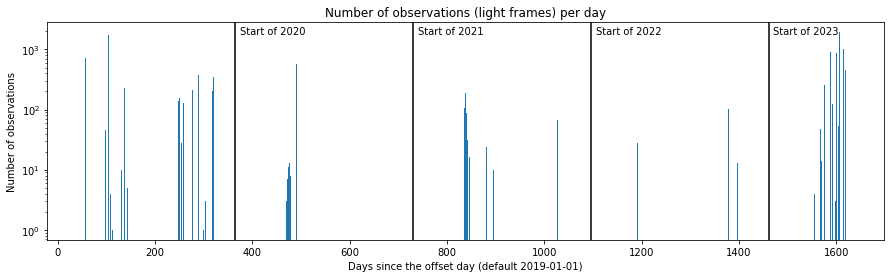

In [8]:
# Prepare the figure
fig = figure(figsize=(15, 4))
ax = fig.add_subplot(1, 1, 1)

# Plot the histogram
n, bins, patches = ax.hist(days, bins=days.max() - days.min())

# Add some year lines
t = Time('2020-01-01T12:00:00.000').mjd - since_date
ax.axvline(t, c='k')
ax.text(t+10, ax.get_ylim()[-1] - ax.get_ylim()[-1]*.1, "Start of 2020")
t = Time('2021-01-01T12:00:00.000').mjd - since_date
ax.axvline(t, c='k')
ax.text(t+10, ax.get_ylim()[-1] - ax.get_ylim()[-1]*.1, "Start of 2021")
t = Time('2022-01-01T12:00:00.000').mjd - since_date
ax.axvline(t, c='k')
ax.text(t+10, ax.get_ylim()[-1] - ax.get_ylim()[-1]*.1, "Start of 2022")
t = Time('2023-01-01T12:00:00.000').mjd - since_date
ax.axvline(t, c='k')
ax.text(t+10, ax.get_ylim()[-1] - ax.get_ylim()[-1]*.1, "Start of 2023")

# Add some labels and a title
ax.set_ylabel('Number of observations')
ax.set_yscale('log')
ax.set_xlabel('Days since the offset day (default 2019-01-01)')
ax.set_title("Number of observations (light frames) per day")
show()

## Example: Plot the Coordinates of all Observations

### Equatorial Coordinates

In [9]:
query = """
SELECT TOP 20000 ra, dec
FROM blaauw.raw
WHERE ra IS NOT NULL 
  AND dec IS NOT NULL
  AND image_type = 'LIGHT'
  AND filename NOT LIKE '%/g/%'
"""

job = vo.launch_job(query)

In [10]:
table = job.get_results()
table.info()

<Table length=18823>
name  dtype  unit                          description                         
---- ------- ---- -------------------------------------------------------------
  ra float64  deg Right Ascention coordinate of where the telescope is pointed.
 dec float64  deg     Declination coordinate of where the telescope is pointed.


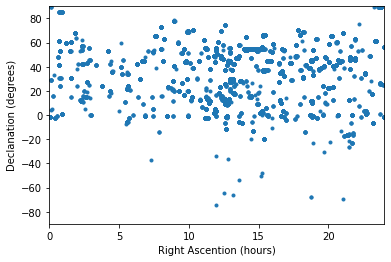

In [11]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

ra = table['ra']
dec = table['dec']
ax.scatter(ra / (360/24), dec, marker='.')

ax.set_ylim(-90, 90)
ax.set_xlim(0, 24)

ax.set_xlabel('Right Ascention (hours)')
ax.set_ylabel('Declanation (degrees)')

show()

We also create a second plot which perhaps is less scientific, but gives a better view on the density of the observations. The rounded effect is done by interpolating (otherwise there would not be a lot visible).

In [12]:
hist2d, xedge, yedge = np.histogram2d(ra, dec, bins=[20, 10], range=[[0, 360], [-90, 90]])
hist2d += 1
hist2d = np.log(hist2d)

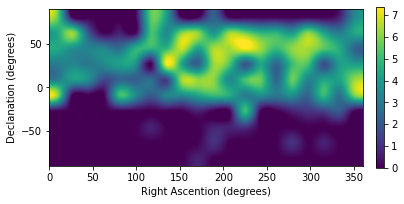

In [13]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

im = ax.imshow(hist2d.T, origin='lower', interpolation='spline16', extent=[0, 360, -90, 90])

ax.set_xlabel('Right Ascention (degrees)')
ax.set_ylabel('Declanation (degrees)')

fig.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
show()

### Horizontal Coordinates

In [14]:
query = """
SELECT TOP 20000 alt, az, telescope
FROM blaauw.raw
WHERE alt IS NOT NULL 
  AND az IS NOT NULL
  AND image_type = 'LIGHT'
  AND filename NOT LIKE '%/g/%'
"""

job = vo.launch_job(query)
table = job.get_results()
table.info()

<Table length=13836>
   name    dtype  unit                                                            description                                                           
--------- ------- ---- ---------------------------------------------------------------------------------------------------------------------------------
      alt float64  deg                                                                                                             Alt-azimutal altitude
       az float64  deg                                                                                                               Alt-azimutal azimut
telescope  object      The telescope which produced the observation, either: GBT (Gratema Bernoulli Telescope) or LDST (Lauwersmeer Dark Sky Telescope).


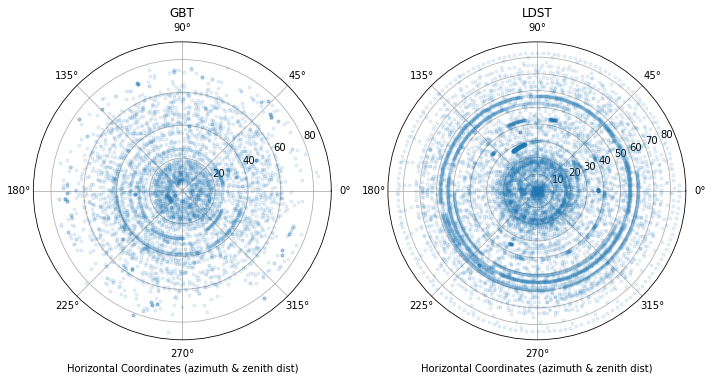

In [15]:
# First convert to zenith distance
alt = table['alt']
table['z'] = np.where(alt > 0, 90 - alt, 0)

# Filter based on telescope
ldst = table[table['telescope'] == "LDST"]
gbt = table[table['telescope'] == "GBT"]

fig = figure(figsize=(10, 10))
ax = fig.add_subplot(1, 2, 1,  polar=True)
ax.plot(gbt['az'], gbt['z'], marker='.', ls='', alpha=0.1)
ax.set_title("GBT")
ax.set_xlabel("Horizontal Coordinates (azimuth & zenith dist)")

ax = fig.add_subplot(1, 2, 2,  polar=True)
ax.plot(ldst['az'], ldst['z'], marker='.', ls='', alpha=0.1)
ax.set_title("LDST")
ax.set_xlabel("Horizontal Coordinates (azimuth & zenith dist)")

fig.tight_layout()
show()

## Example: Retrieving all Filenames Satisfying a Certain Query

In [16]:
object_name = "Jupiter"

query = """
SELECT filename, target_object, ra, dec, date_obs
FROM blaauw.raw
WHERE target_object = '{}'
ORDER BY date_obs
""".format(object_name)

job = vo.launch_job(query)
table = job.get_results()

In [17]:
filenames = table['filename']

# Print part of the resulting list on separate lines
print('\n'.join(filenames[:6]))
print('...')
print('\n'.join(filenames[-6:]))

/net/vega/data/users/observatory/images/080925/STL-6303E/i/Jupiter2.fits
/net/vega/data/users/observatory/images/080925/STL-6303E/i/Jupiter3.fits
/net/vega/data/users/observatory/images/080926/STL-6303E/i/Jupiter0.fits
/net/vega/data/users/observatory/images/080927/STL-6303E/i/JupiterR0,2s1.fits
/net/vega/data/users/observatory/images/080927/STL-6303E/i/JupiterV0,2s2.fits
/net/vega/data/users/observatory/images/080927/STL-6303E/i/JupiterV10s3.fits
...
/net/vega/data/users/observatory/images/220921/STL-6303E/i/220921_Li_.00000077.Jupiter.BIAS.FIT
/net/vega/data/users/observatory/images/220921/STL-6303E/i/220921_Li_.00000078.Jupiter.BIAS.FIT
/net/vega/data/users/observatory/images/220921/STL-6303E/i/220921_Li_.00000079.Jupiter.BIAS.FIT
/net/vega/data/users/observatory/images/220921/STL-6303E/i/220921_Li_.00000080.Jupiter.BIAS.FIT
/net/vega/data/users/observatory/images/220921/STL-6303E/i/220921_Li_.00000081.Jupiter.BIAS.FIT
/net/vega/data/users/observatory/images/220921/STL-6303E/i/22092

## Example: Selecting Observations Closest to a Given Date

In [18]:
# night of the 17th of April 2020
ref_date = Time("2020-04-18T01:25:53.895").mjd

query = """
SELECT TOP 100 filename, date_obs, ABS(date_obs_mjd - {}) AS difference
FROM blaauw.raw
ORDER BY difference
""".format(ref_date)

job = vo.launch_job(query)
table = job.get_results()

Now more specific (an example from my own Observational Astronomy project).

We had the case where we needed 3x3 binned Flat Field images, but only 1x1 binned were taken on that night. So, we wanted to find the next best thing, which are the most recent 3x3 flats relative to our observation night.

In addition, we solve the issue of the absolute difference, which can lead to a mix of results from before and after the date.

In [19]:
query = """
SELECT TOP 10 filename, date_obs, filter,
              ABS(date_obs_mjd - {0}) AS abs_difference,
              date_obs_mjd - {0} AS difference
FROM blaauw.raw
WHERE image_type = 'FLAT' AND binning = 3
ORDER BY abs_difference
""".format(ref_date)

job = vo.launch_job(query)
table = job.get_results()

In [20]:
selector = table['difference'] < 0

print('Taken before date:')
print(table[selector]['filename'])

print()
print()

print('Taken after date:')
print(table[~selector]['filename'])

Taken before date:
filename
--------


Taken after date:
                                                   filename                                                   
--------------------------------------------------------------------------------------------------------------
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000030.13h13m22.7s_27d58m22sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000031.13h13m29.8s_27d58m47sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000032.13h13m36.8s_27d59m13sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000033.13h13m44.8s_27d59m38sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000034.13h13m50.8s_28d00m04sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303E/i/200418_Li_.00000035.13h13m59.8s_28d00m30sN.FLAT.FIT
/net/vega/data/users/observatory/images/200418/STL-6303

### A more specific query: find closest flats to a night
This issue arises often when you were not able to take (good) flats on your night. So, we want to find flats close to our observed night.

In [21]:
# night of the 17th of April 2020
ref_date = Time("2020-04-18T01:25:53.895").mjd

query = """
SELECT TOP 20 filename, date_obs, filter,
              ABS(date_obs_mjd - {0}) AS abs_difference,
              date_obs_mjd - {0} AS difference
FROM blaauw.raw
WHERE image_type = 'FLAT'
  AND binning = 1 
  AND filter = 'H-alpha'
  AND telescope = 'GBT'

ORDER BY abs_difference
""".format(ref_date)

job = vo.launch_job(query)
table = job.get_results()
table

filename,date_obs,filter,abs_difference,difference
,,,,d
object,object,object,float64,float64
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000032.08h43m18.4s_00d14m39sN.FLAT.FIT,2020-04-19T18:45:28.015000,H-alpha,1.7219226851884741,1.7219226851884741
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000033.08h43m23.4s_00d15m04sN.FLAT.FIT,2020-04-19T18:45:58.118000,H-alpha,1.7222710995338275,1.7222710995338275
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000034.08h43m29.4s_00d15m30sN.FLAT.FIT,2020-04-19T18:46:26.471000,H-alpha,1.7225992592575494,1.7225992592575494
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000035.08h43m33.4s_00d15m56sN.FLAT.FIT,2020-04-19T18:46:54.449000,H-alpha,1.7229230787052074,1.7229230787052074
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000036.08h43m39.4s_00d16m22sN.FLAT.FIT,2020-04-19T18:47:23.103000,H-alpha,1.7232547222229186,1.7232547222229186
/net/vega/data/users/observatory/images/220419/STL-6303E/i/220419_Li_.00000001.M_101.FLAT.FIT,2022-04-19T18:44:48.880000,H-alpha,731.7214697337986,731.7214697337986
/net/vega/data/users/observatory/images/220419/STL-6303E/i/220419_Li_.00000002.M_101.FLAT.FIT,2022-04-19T18:45:18.583000,H-alpha,731.7218135185176,731.7218135185176
/net/vega/data/users/observatory/images/220419/STL-6303E/i/220419_Li_.00000003.M_101.FLAT.FIT,2022-04-19T18:45:47.972000,H-alpha,731.7221536689831,731.7221536689831


Now, we group the observations per night.  We identify the night by truncating the mjd to the nearest lower integer (subtracted by 0.5). We can see that there were flats taken the night after.

In [22]:
nights = table.group_by(np.floor(table['abs_difference'] - 0.5))
for night, key in zip(nights.groups, nights.groups.keys):
    print(key)
    print(night['date_obs'])

1.0
         date_obs         
--------------------------
2020-04-19T18:45:28.015000
2020-04-19T18:45:58.118000
2020-04-19T18:46:26.471000
2020-04-19T18:46:54.449000
2020-04-19T18:47:23.103000
731.0
         date_obs         
--------------------------
2022-04-19T18:44:48.880000
2022-04-19T18:45:18.583000
2022-04-19T18:45:47.972000
2022-04-19T18:46:16.996000
2022-04-19T18:46:46.039000
2022-04-20T04:02:53.219000
2022-04-20T04:03:24.546000
2022-04-20T04:03:55.921000
2022-04-20T04:04:27.141000
2022-04-20T04:04:58.478000
756.0
         date_obs         
--------------------------
2022-05-14T19:30:31.677000
2022-05-14T19:30:59.876000
2022-05-14T19:31:27.519000
2022-05-14T19:31:54.342000
2022-05-14T19:32:22.151000


Now we retrieve the files of these flats, and check if they are good. Note, that this requires that we have access to these files (i.e. we need to be on the Kapteyn network)

In [23]:
night = nights.groups[0]

flat_data = []
for filename in night['filename']:
    with fits.open(filename) as hdul:
        flat_data.append(hdul[0].data)

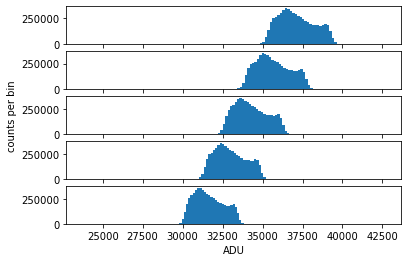

In [24]:
fig = figure()
ax = None
for i, data in enumerate(flat_data):
    ax = fig.add_subplot(5, 1, i+1, sharex=ax)
    ax.hist(data.flatten(), bins=100)
    if i == 2:
        ax.set_ylabel("counts per bin")
#     ax.set_yticklabels([])
# fig.tight_layout()
ax.set_xlabel("ADU")
show()

The flats seem to be good, so now we could copy them to a directory we want to use them for data reduction

In [25]:
for fn in night['filename']:
    print(fn)

/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000032.08h43m18.4s_00d14m39sN.FLAT.FIT
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000033.08h43m23.4s_00d15m04sN.FLAT.FIT
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000034.08h43m29.4s_00d15m30sN.FLAT.FIT
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000035.08h43m33.4s_00d15m56sN.FLAT.FIT
/net/vega/data/users/observatory/images/200419/STL-6303E/i/200419_Li_.00000036.08h43m39.4s_00d16m22sN.FLAT.FIT


## Example: Using SIMBAD to Search the Database
In this example, we will use SIMBAD to query the database by an object's name. Essentially this mimics the Cone Search service from the web interface. For this example, we will use the Messier objects which are designated with an M and then a number. This means we can use a wildcard for the number, like `M *`.

This example also shows how to add a new field/column in the output of a SIMBAD query (in this case the object type `otype`).

In [26]:
from astroquery.simbad import Simbad
from astropy import units as u

customSimbad = Simbad()
customSimbad.add_votable_fields('otype')
# Uncomment to list all the fields/columns it can return
#customSimbad.list_votable_fields()

# Query all the mesier objects from SIMBAD
result_table = customSimbad.query_object("M *", wildcard=True)
print(result_table)

 MAIN_ID        RA           DEC      ...     OTYPE     SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                               
--------- ------------- ------------- ... ------------- ----------------
    M   1    05 34 30.9     +22 00 53 ...     SNRemnant                1
    M   2   21 33 27.02   -00 49 23.7 ...   GlobCluster                1
    M   3   13 42 11.62   +28 22 38.2 ...   GlobCluster                1
    M   4   16 23 35.22   -26 31 32.7 ...   GlobCluster                1
    M   5   15 18 33.22   +02 04 51.7 ...   GlobCluster                1
NGC  6405    17 40 16.6     -32 14 31 ...   OpenCluster                1
NGC  6475    17 53 47.3     -34 50 28 ...   OpenCluster                1
    M   8      18 03 37      -24 23.2 ...        HIIReg                1
    M   9   17 19 11.78   -18 30 58.5 ...   GlobCluster                1
    M  10   16 57 09.05   -04 06 01.1 ...   GlobCluster                1
      ...           ...           ... ...          

In [27]:
# Put the ra and dec coordinates in SkyCoord so we can convert it to degrees
sc = SkyCoord(result_table['RA'], result_table['DEC'], unit=(u.hourangle, u.deg))

query = """
SELECT filename FROM blaauw.raw
WHERE image_type = 'LIGHT' AND CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {}, {}, {}))=1
"""

In [28]:
# Loop over all the coordinates & their table entry
print('    MAIN ID     |  Obj Type  | Num Entries')
print('----------------+------------+------------')
for coords, obj in zip(sc, result_table):
    q = query.format(coords.ra.deg, coords.dec.deg, 1)  # 1 is for the circle radius in degrees
    job = vo.launch_job(q)
    table = job.get_results()

    if len(table) > 0:
        print('{:15s} | {:20} | {:3d}'.format(obj['MAIN_ID'], obj['OTYPE'], len(table)))

    MAIN ID     |  Obj Type  | Num Entries
----------------+------------+------------
M   1           | SNRemnant            |  26
M   3           | GlobCluster          | 163
M   5           | GlobCluster          |   4
M  10           | GlobCluster          |   7
M  12           | GlobCluster          |   6
M  13           | GlobCluster          | 1476
M  14           | GlobCluster          |   4
M  15           | GlobCluster          |  61
M  16           | OpenCluster          |   6
M  27           | PlanetaryNeb         | 135
M  29           | OpenCluster          |   1
M  30           | GlobCluster          |   7
M  31           | Galaxy               |  53
M  32           | InteractingG         |  50
M  33           | GtowardsGroup        |  27
NGC  1039       | OpenCluster          |   8
M  36           | OpenCluster          |  10
NGC  7092       | OpenCluster          |  40
M  40           | Unknown              |   6
M  42           | HIIReg               | 158
M  43        